## Work Notebook for Requirements Engineering Journal Article

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

import research_utils.utils as utils
from research_utils.database.database import Database
from research_utils.analytics.beta_regression import Beta
from research_utils.analytics.lda import TopicModel

In [2]:
database = Database()

In [3]:
data = pd.read_sql(utils.INPUT_QUERY, database.connection)

In [4]:
tm = TopicModel(25, load=True)

In [5]:
df = tm.load_topic_model_results()

In [6]:
df.head()

,issue_time,issue_id,title,body,organization,package,issue_number,all_content,topics
0,2018-05-03 11:33:46,319883485,"Help command line arguments (-h, --help) are i...",The help arguments implicitly defined by the a...,actor-framework,actor-framework,688,"Help command line arguments (-h, --help) are i...","[0.009083141572773457, 0.009083141572773457, 0..."
1,2015-02-24 20:11:09,58796753,Remove match expr,The main objective of this change is to make C...,actor-framework,actor-framework,242,Remove match expr The main objective of this c...,"[0.006975634954869747, 0.006975634954869747, 0..."
2,2014-12-18 16:09:28,52381894,Enable actor publishing at random high-level port,"With this patch, using 0 as port parameter to ...",actor-framework,actor-framework,218,Enable actor publishing at random high-level p...,"[0.008186651393771172, 0.008186651393771172, 0..."
3,2018-01-08 17:03:43,286813990,The udp basp autoconnection test has a leak,"According to asan, there is a leak in the unit...",actor-framework,actor-framework,647,The udp basp autoconnection test has a leak Ac...,"[0.010533114895224571, 0.3219645917415619, 0.0..."
4,2014-12-17 11:32:12,52229707,Topic/pullrequest,More tests for the jenkins PR builder.\n,actor-framework,actor-framework,216,Topic/pullrequest More tests for the jenkins P...,"[0.013114626519382, 0.013114626519382, 0.01311..."


In [7]:
for i in range(tm.num_topics):
    df['topic_{}'.format(i)] = [x[i] if x else np.nan for x in df['topics']]
    df['topic_{}_2'.format(i)] = df['topic_{}'.format(i)]**2

In [8]:
all_topics = []
reg_topics = []
for i in range(tm.num_topics-1):    
    all_topics.append('topic_{}'.format(i))
    all_topics.append('topic_{}_2'.format(i))
    for j in range(tm.num_topics-1):
        reg_topics.append("topic_{}*topic_{}".format(i, j))
        reg_topics.append("topic_{}_2".format(i, j))

In [9]:
mean_topics = df.groupby(['organization', 'package']).mean()[all_topics]

In [10]:
all_data = mean_topics.merge(data, on=['package', 'organization'])

In [11]:
all_data['crowd_pct_sq'] = np.sqrt(all_data['crowd_pct'])
all_data['crowd_pct_2'] = all_data['crowd_pct']**2
all_data['issues_over_time'] = (all_data['total_issues'] / all_data['project_age'])*7
all_data['avg_clusteringXcrowd_pct'] = all_data['avg_clustering'] * all_data['crowd_pct']
all_data['avg_min_pathXcrowd_pct'] = all_data['avg_min_path'] * all_data['crowd_pct']
all_data['gini_coefficientXcrowd_pct'] = all_data['gini_coefficient'] * all_data['crowd_pct']

In [12]:
base_columns = ['crowd_pct', 'crowd_pct_2',
                'avg_clustering', 'avg_min_path', 'gini_coefficient',
                'avg_clusteringXcrowd_pct', 'avg_min_pathXcrowd_pct', 'gini_coefficientXcrowd_pct',
                'total_contributors', 'project_age']
base_features = ' + '.join(base_columns)

### Regression on Average Comments

In [13]:
y, X = dmatrices('avg_comments ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     21.78
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           2.32e-34
Time:                        18:56:05   Log-Likelihood:                -746.16
No. Observations:                 562   AIC:                             1514.
Df Residuals:                     551   BIC:                             1562.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [14]:
y, X = dmatrices('avg_comments ~ ' + base_features + ' + ' + ' + '.join(reg_topics),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, .05)
y, X = dmatrices('avg_comments ~ ' + features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     9.776
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           3.30e-41
Time:                        18:56:24   Log-Likelihood:                -685.68
No. Observations:                 562   AIC:                             1451.
Df Residuals:                     522   BIC:                             1625.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

(-2.0, 2.0)

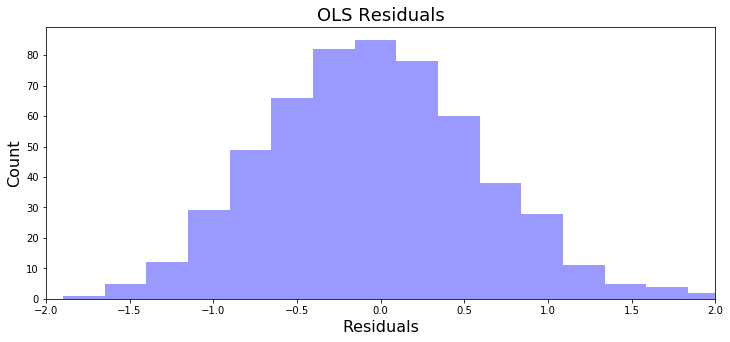

In [15]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-2.0, 2.0])

(-2.0, 2.0)

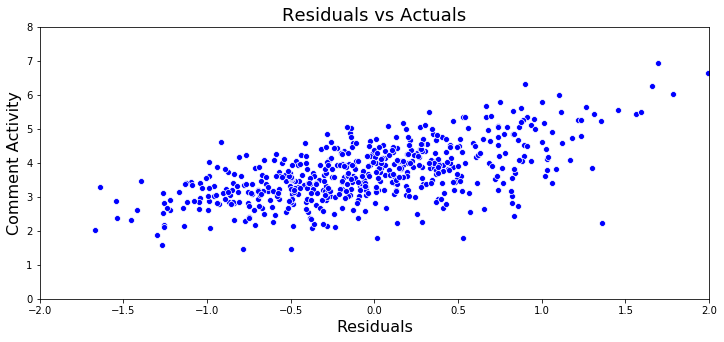

In [16]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Comment Activity', fontsize=16)
plt.ylim([0, 8])
plt.xlim([-2.0, 2.0])

In [17]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(res.summary())

2019-12-08 18:56:26,565 [2004] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.5024091203156327
                 Generalized Linear Model Regression Results                  
Dep. Variable:           avg_comments   No. Observations:                  562
Model:                            GLM   Df Residuals:                      522
Model Family:                   Gamma   Df Model:                           39
Link Function:                    log   Scale:                        0.039572
Method:                          IRLS   Log-Likelihood:                -575.73
Date:                Sun, 08 Dec 2019   Deviance:                       18.892
Time:                        18:56:26   Pearson chi2:                     20.7
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Inter

In [18]:
all_data['comment_prediction'] = res.predict(X)

(0, 1.5)

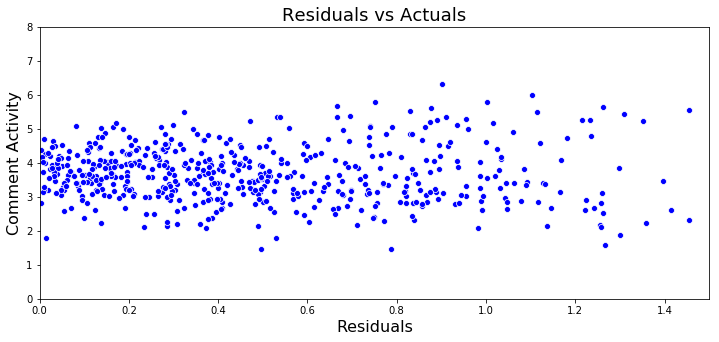

In [19]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=abs(yhat - all_data['avg_comments']), y=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Comment Activity', fontsize=16)
plt.ylim([0, 8])
plt.xlim([0, 1.5])

In [20]:
marginal_effects = {'crowd_pct': [], 'effect': []}
for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['crowd_pct_2'] = crowd_pct**2
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*all_data['avg_clustering']
    effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*all_data['avg_min_path']
    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
    effects_data['crowd_pct_param'] = (effects_data['avg_clustering'] * res.params['avg_clusteringXcrowd_pct']
                                       + effects_data['avg_min_path'] * res.params['avg_min_pathXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] *crowd_pct
                                                                  + effects_data['crowd_pct_param'])
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
marginal_effects = pd.DataFrame(marginal_effects)

Text(0.5, 0, 'Crowd Source Percentage')

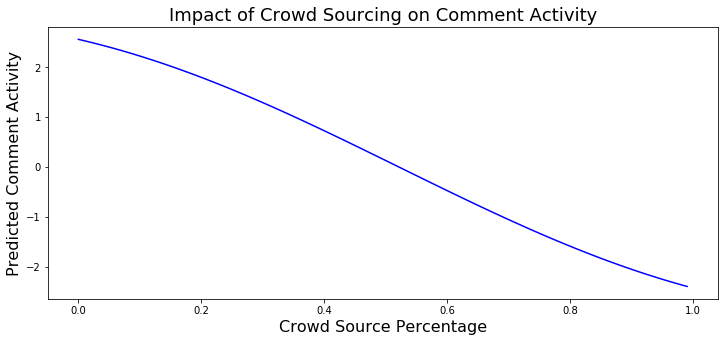

In [21]:
plt.figure(figsize=(12, 5))
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], color='blue')
plt.title('Impact of Crowd Sourcing on Comment Activity', fontsize=18)
plt.ylabel('Predicted Comment Activity', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

In [22]:
all_data[['avg_clustering', 'avg_min_path']].describe()

,avg_clustering,avg_min_path
count,562.000000,562.000000
mean,0.601003,2.187393
std,0.140855,0.232263
min,0.000000,1.400000
25%,0.522477,2.012390
50%,0.627541,2.145767
75%,0.704530,2.331743
max,0.878524,3.054147


Text(0.5, 0, 'Crowd Source Percentage')

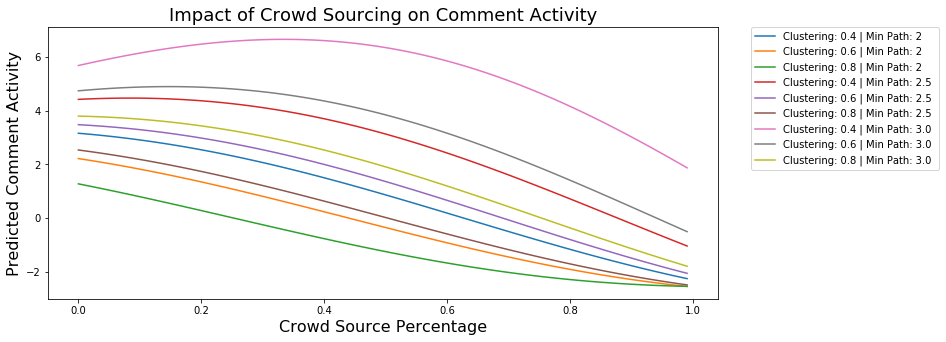

In [23]:
combos = [(0.4, 2),
          (0.6, 2),
          (0.8, 2),
          (0.4, 2.5),
          (0.6, 2.5),
          (0.8, 2.5),
          (0.4, 3.0),
          (0.6, 3.0),
          (0.8, 3.0)]

plt.figure(figsize=(12, 5))

for combo in combos:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    avg_clustering, avg_min_path = combo
    label = 'Clustering: {} | Min Path: {} '.format(avg_clustering, avg_min_path)
    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['crowd_pct_2'] = crowd_pct**2
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Impact of Crowd Sourcing on Comment Activity', fontsize=18)
plt.ylabel('Predicted Comment Activity', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

### Regression on Mean Requirement Duration

In [24]:
y, X = dmatrices('duration_mean ~ ' + base_features + ' + total_issues ',
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          duration_mean   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     22.62
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           2.75e-38
Time:                        18:56:44   Log-Likelihood:                -3524.3
No. Observations:                 562   AIC:                             7073.
Df Residuals:                     550   BIC:                             7125.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [25]:
y, X = dmatrices('duration_mean ~ ' + base_features + ' + total_issues + ' + ' + '.join(reg_topics),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, .10)
y, X = dmatrices('duration_mean ~ crowd_pct + avg_clusteringXcrowd_pct - avg_clustering ' + features ,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          duration_mean   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     7.749
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           2.21e-48
Time:                        18:57:12   Log-Likelihood:                -3401.2
No. Observations:                 562   AIC:                             6960.
Df Residuals:                     483   BIC:                             7303.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

(-250, 250)

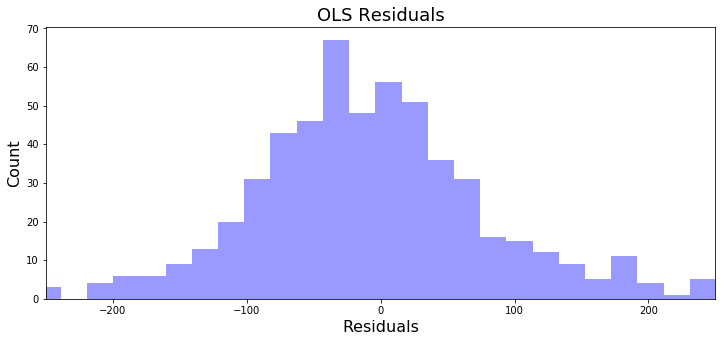

In [26]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-250, 250])

(-200, 200)

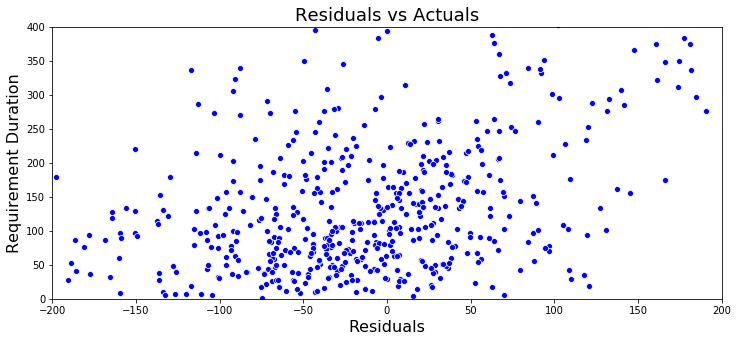

In [27]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['duration_mean'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Requirement Duration', fontsize=16)
plt.ylim([0, 400])
plt.xlim([-200, 200])

In [28]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(res.summary())
yhat = res.predict(X)

2019-12-08 18:57:13,822 [2004] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.5089908842452362
                 Generalized Linear Model Regression Results                  
Dep. Variable:          duration_mean   No. Observations:                  562
Model:                            GLM   Df Residuals:                      483
Model Family:                   Gamma   Df Model:                           78
Link Function:                    log   Scale:                         0.40315
Method:                          IRLS   Log-Likelihood:                -3195.2
Date:                Sun, 08 Dec 2019   Deviance:                       220.32
Time:                        18:57:14   Pearson chi2:                     195.
No. Iterations:                    31                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Inter

In [29]:
all_data['duration_prediction'] = res.predict(X)

(0, 200)

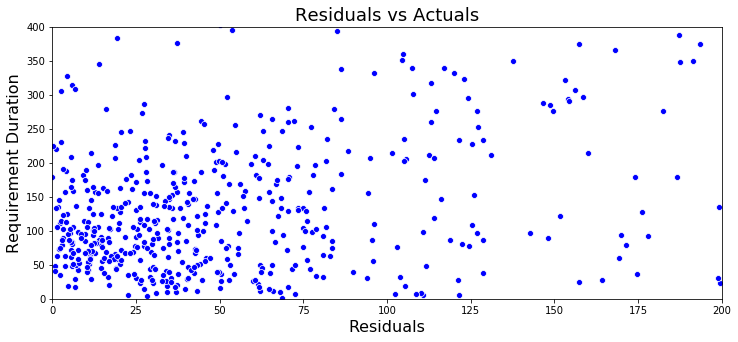

In [30]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=abs(yhat - all_data['duration_mean']), y=all_data['duration_mean'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Requirement Duration', fontsize=16)
plt.ylim([0, 400])
plt.xlim([0, 200])

In [31]:
marginal_effects = {'crowd_pct': [], 'effect': []}
for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['crowd_pct'] = crowd_pct
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*all_data['avg_clustering']
    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_effect'] = effects_data['predictions'] * res.params['crowd_pct']
    effects_data['crowd_pct_param'] = (all_data['avg_clustering'] * res.params['avg_clusteringXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * (res.params['crowd_pct'] * crowd_pct
                                                                  + effects_data['crowd_pct_param'])
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
marginal_effects = pd.DataFrame(marginal_effects)

Text(0.5, 0, 'Crowd Source Percentage')

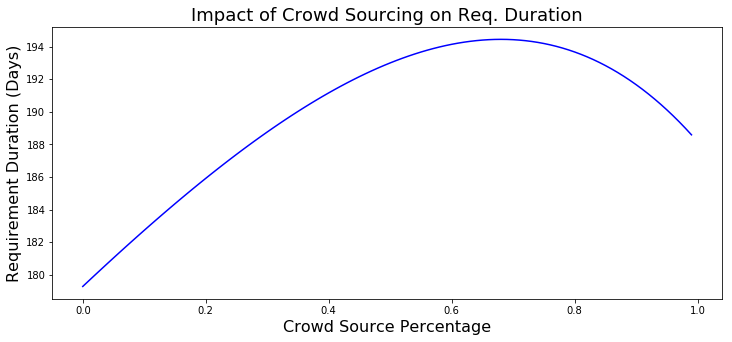

In [32]:
plt.figure(figsize=(12, 5))
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], color='blue')
plt.title('Impact of Crowd Sourcing on Req. Duration', fontsize=18)
plt.ylabel('Requirement Duration (Days)', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

Text(0.5, 0, 'Crowd Source Percentage')

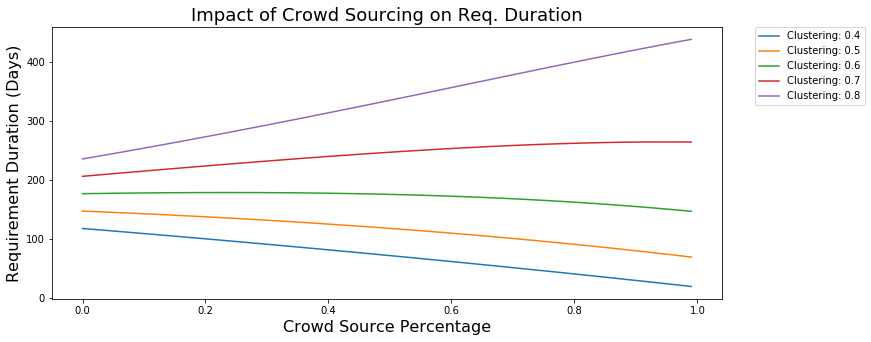

In [33]:
plt.figure(figsize=(12, 5))
for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Clustering: {}'.format(avg_clustering)
    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['crowd_pct'] = crowd_pct
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct * avg_clustering
        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_effect'] = effects_data['predictions'] * res.params['crowd_pct']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (res.params['crowd_pct'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Impact of Crowd Sourcing on Req. Duration', fontsize=18)
plt.ylabel('Requirement Duration (Days)', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

### Regression on Issues Submitted Over Time

In [34]:
y, X = dmatrices('issues_over_time ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       issues_over_time   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     46.23
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           1.41e-66
Time:                        18:57:25   Log-Likelihood:                -419.96
No. Observations:                 562   AIC:                             861.9
Df Residuals:                     551   BIC:                             909.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [35]:
y, X = dmatrices('issues_over_time ~ ' + base_features + ' + ' + ' + '.join(reg_topics),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, .05)
y, X = dmatrices('issues_over_time ~ ' + features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       issues_over_time   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     22.90
Date:                Sun, 08 Dec 2019   Prob (F-statistic):          9.38e-118
Time:                        18:57:43   Log-Likelihood:                -169.80
No. Observations:                 562   AIC:                             489.6
Df Residuals:                     487   BIC:                             814.5
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [36]:
all_data['issue_fresuency_prediction'] = res.predict(X)

(-1.0, 1.0)

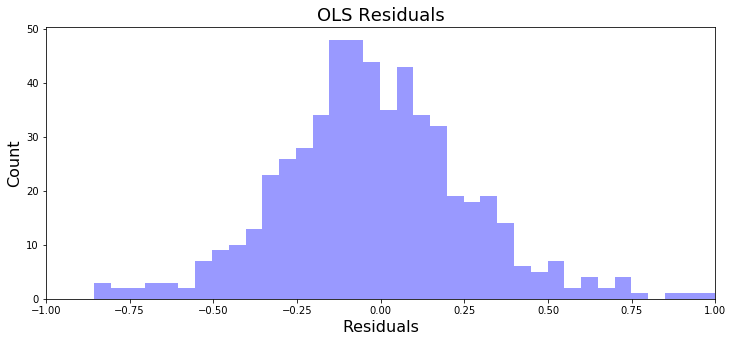

In [37]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-1.0, 1.0])

(-0.75, 0.75)

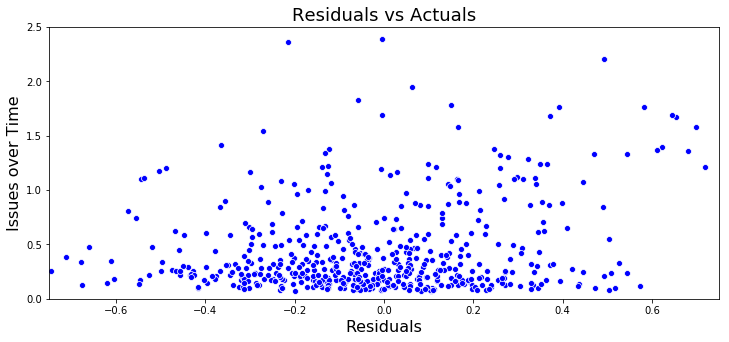

In [38]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['issues_over_time'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Issues over Time', fontsize=16)
plt.ylim([0, 2.5])
plt.xlim([-0.75, .75])

In [39]:
marginal_effects = {'crowd_pct': [], 'effect': []}
for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['crowd_pct_2'] = crowd_pct**2
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*all_data['avg_clustering']
    effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*all_data['avg_min_path']
    effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*all_data['gini_coefficient']
    effects_data['crowd_pct_param'] = (all_data['avg_clustering'] * res.params['avg_clusteringXcrowd_pct']
                                       + all_data['avg_min_path'] * res.params['avg_min_pathXcrowd_pct']
                                       + all_data['gini_coefficient'] * res.params['gini_coefficientXcrowd_pct'])
    effects_data['total_effect'] = effects_data['crowd_pct_param'] + (2 * res.params['crowd_pct_2'] * crowd_pct)
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
marginal_effects = pd.DataFrame(marginal_effects)

Text(0.5, 0, 'Crowd Source Percentage')

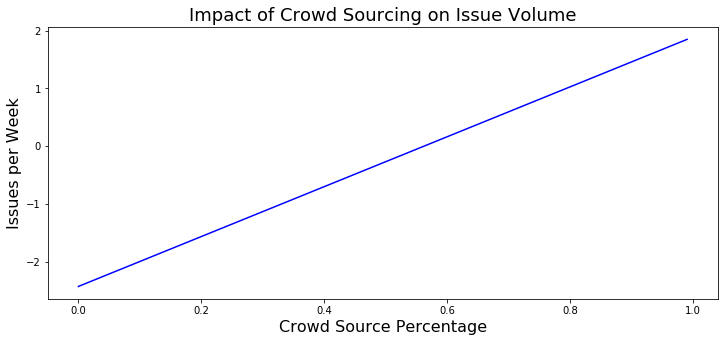

In [40]:
plt.figure(figsize=(12, 5))
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], color='blue')
plt.title('Impact of Crowd Sourcing on Issue Volume', fontsize=18)
plt.ylabel('Issues per Week', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

Text(0.5, 0, 'Crowd Source Percentage')

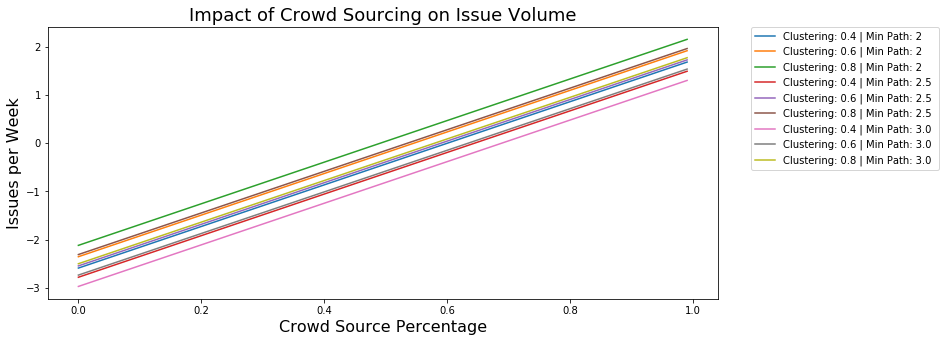

In [41]:
combos = [(0.4, 2),
          (0.6, 2),
          (0.8, 2),
          (0.4, 2.5),
          (0.6, 2.5),
          (0.8, 2.5),
          (0.4, 3.0),
          (0.6, 3.0),
          (0.8, 3.0)]

plt.figure(figsize=(12, 5))

for combo in combos:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    avg_clustering, avg_min_path = combo
    label = 'Clustering: {} | Min Path: {} '.format(avg_clustering, avg_min_path)
    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['crowd_pct_2'] = crowd_pct**2
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct* avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct * avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct * all_data['gini_coefficient']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                           + all_data['gini_coefficient'] * res.params['gini_coefficientXcrowd_pct'])
        effects_data['total_effect'] = effects_data['crowd_pct_param'] + (2 * res.params['crowd_pct_2'] * crowd_pct)
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
    marginal_effects = pd.DataFrame(marginal_effects)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Impact of Crowd Sourcing on Issue Volume', fontsize=18)
plt.ylabel('Issues per Week', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

### Regression on Document Diversity

In [42]:
num_topics = []
for i in all_data.index:
    topics = 0
    for j in range(25):
        if df.loc[i]['topic_{}'.format(j)] > topics:
            topics = df.loc[i]['topic_{}'.format(j)]
    num_topics.append(topics)
all_data['num_topics'] = num_topics